In [ ]:
pip install boto3 farm-haystack pyPDF2 pymuPDF easyocr faiss-gpu

In [2]:
import boto3
import json
import base64

bedrock = boto3.client('bedrock-runtime')

MULTIMODAL EMBEDDINGS

IMAGE TO EMBED ->

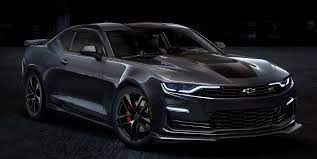

In [3]:
# read in image and create embeddings for image and caption
with open("/content/sample_data/camaro.jfif", "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')


body = json.dumps(
    {
        "inputText": "gray camaro",
        "inputImage": input_image
    }
)

In [4]:
response = bedrock.invoke_model(
	body=body,
	modelId="amazon.titan-embed-image-v1",
	accept="application/json",
	contentType="application/json"
)

In [5]:
response_body = json.loads(response.get("body").read())
car_embedding = response_body.get("embedding")
car_embedding[:2]

[-0.0022371383, 0.033632398]

In [7]:
# Vector embedding of similar caption
def embed(text):
  body = json.dumps(
      {
          "inputText": text,
      }
  )
  response = bedrock.invoke_model(
	body=body,
	modelId="amazon.titan-embed-image-v1",
	accept="application/json",
	contentType="application/json"
  )
  response_body = json.loads(response.get("body").read())
  text_embedding = response_body.get("embedding")
  return text_embedding

In [8]:
text = 'car with stripes'
text_embedding = embed(text)
text_embedding[:2]

[0.040283203, -0.0007209778]

In [9]:
# Calculate cosine similarity with caption
import numpy as np

dot_product = np.dot(np.array(car_embedding), np.array(text_embedding))
norm_vector1 = np.linalg.norm(car_embedding)
norm_vector2 = np.linalg.norm(text_embedding)
cosine_similarity_value = dot_product / (norm_vector1 * norm_vector2)
print(f'Cosine similarity is {cosine_similarity_value}')

Cosine similarity is 0.5786531198621794


In [10]:
with open("/content/sample_data/camaro.jfif", "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')


body = json.dumps(
    {
        "inputImage": input_image
    }
)
response = bedrock.invoke_model(
	body=body,
	modelId="amazon.titan-embed-image-v1",
	accept="application/json",
	contentType="application/json"
)
response_body = json.loads(response.get("body").read())
car_embedding = response_body.get("embedding")
car_embedding[:2]

[0.0015071685, 0.045170065]

In [11]:
# Calculate cosine similarity without caption
import numpy as np

dot_product = np.dot(np.array(car_embedding), np.array(text_embedding))
norm_vector1 = np.linalg.norm(car_embedding)
norm_vector2 = np.linalg.norm(text_embedding)
cosine_similarity_value = dot_product / (norm_vector1 * norm_vector2)
print(f'Cosine similarity is {cosine_similarity_value}')

Cosine similarity is 0.39729774544583


In [ ]:
np.array(car_embedding).shape

(1024,)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix = cosine_similarity([car_embedding], [text_embedding])
cosine_similarity_value_sklearn = cosine_similarity_matrix[0, 0]
cosine_similarity_value_sklearn

0.732990624393507

In [ ]:
# Misses content embedded in photos within the PDF
import PyPDF2

def extract_text(pdf_path):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(pdf_reader.pages)):
            text += pdf_reader.pages[page_num].extract_text()
    return text

# Skips page 7
pdf_text = extract_text('/content/sample_data/aws-ml.pdf').strip().replace('\n\n', '')
print(pdf_text)


In [13]:
import fitz  # PyMuPDF-Fitz
from haystack.schema import Document
import easyocr
import base64

docs = []
reader = easyocr.Reader(['en'], gpu=True) # this needs to run only once to load the model into memory

def extract_text_and_images_from_pdf(pdf_path, output_folder):
    # Open the PDF document
    pdf_document = fitz.open(pdf_path)
    img_bytes = None
    for page_num in range(pdf_document.page_count):
        # Extract text
        page = pdf_document[page_num]
        text = page.get_text("text")

        # Extract images
        img_bytes = []
        images = page.get_images(full=True)
        if len(images) > 0:
          img_bytes = []
          for img_index, img_info in enumerate(images):
              image_index = img_info[0]
              base_image = pdf_document.extract_image(image_index)
              image_bytes = base_image["image"]
              image_path = f"test.png"
              with open(image_path, 'wb') as image_file:
                  image_file.write(image_bytes)

              result = reader.readtext('test.png', detail=0)
              result = ' '.join(result)
              text += f'\n {result}'
              img_bytes.append(base64.b64encode(image_bytes).decode('utf-8'))

        docs.append(Document(content=text, embedding=embed(text), meta={"document_name":pdf_path, "page":page_num+1, "img_bytes":img_bytes}))
        if len(docs) > 5:
            break
    pdf_document.close()

    return docs


docs = extract_text_and_images_from_pdf('/content/sample_data/aws-ml.pdf', '/content/sample_data/')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
from pprint import pprint
pprint(docs)

[<Document: {'content': 'AWS Machine Learning Specialty \nCheat Sheet \nFabrice Guillaume - Nov 2020 \n \n \nS3: \n-\nFiles can be from 0 bytes to 5Tb \n-\nUnlimited storage \n-\nUniversal namespace (names must be unique globally) \n \nDBs: \n-\nRDS:\u200b Relational DB (MySQL, SQL Server, Oracle, Postgres, Aurora, MariaDB) \n-\nDynamoDB\u200b: NoSQL \n-\nRedShift\u200b: BI datawarehouse / Redshift spectrum can query data from S3 and we acn \nuse Quicksight on top for visualization \n-\nTimeStream\u200b: to handle time series data \n-\nDocumentDB\u200b: for Mongo \n \nAWS Migration Tools: \n-\nData Pipeline\u200b: NEED EC2 instances and/or EMR. Used \u200bfor creating ETL workflows to \nautomate processing of data at scheduled intervals, then terminate the \nresources. \nAWS data pipeline can be used to move data from one dynamoDB table in \none region to another region. \u200bBehind the scenes it launches EMR cluster \n-> stores in S3 -> starts EMR in the other region, Loads from S3 a

In [15]:
from haystack.document_stores import FAISSDocumentStore
import faiss
docstore = FAISSDocumentStore(embedding_dim=1024, faiss_index_factory_str="Flat")
docstore.write_documents(docs)

Writing Documents: 10000it [00:00, 281659.48it/s]       


In [20]:
text = 'how do i address underfitting and overfitting?'
emb = embed(text)
context = docstore.query_by_embedding(np.array(emb), top_k=2)
pprint(context)

[<Document: {'content': 'Addressing UnderFitting and OverFitting \nhttps://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.htm\nl \n \n \nYour model is \u200bunderfitting\u200b the training data when the model performs poorly on the training \ndata. This is because the model is unable to capture the relationship between the input \nexamples (often called X) and the target values (often called Y).  \nYour model is \u200boverfitting\u200b your training data when you see that the model performs well on the \ntraining data but does not perform well on the evaluation data. This is because the model is \nmemorizing the data it has seen and is unable to generalize to unseen examples. \n \n \nIf your model is \u200bunderfitting => poor performance on the training\u200b data could be because the \nmodel is too simple (the input features are not expressive enough) to describe the target well. \nPerformance can be improved by\u200b increasing model flexibility

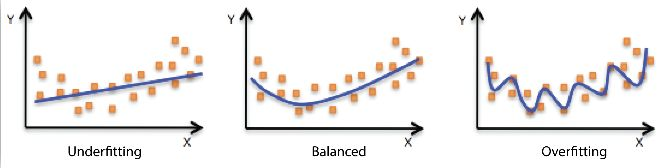

In [21]:
from PIL import Image
from IPython.display import display, Image as IPImage
import io

img_bytes = context[0].meta['img_bytes'][0]
# print(img_bytes)
# image_base64 = base64.b64encode(img_bytes).decode('utf-8')
image_data = base64.b64decode(img_bytes)
# Now 'image_base64' contains the base64-encoded string
image_path = f"testingggg.png"
with open(image_path, 'wb') as image_file:
    image_file.write(image_data)
display(IPImage(filename=image_path))